### Mapping time-delay embedding of partial measurements to full-state attractor

For access on Google Colab, use this link: https://colab.research.google.com/drive/1CNh5cUk6OH1bHposHS2u3P4UUk6reS70?usp=sharing

WARNING: this notebook is has some bugs and *problems*!


- Import basics
- Look at the data
- Lorenz
	- Plot data
	- Hankel
	- Dominant modes

- Import torch, functional, optim
- torch basics: tensor, 
- Building a network
	- sequential network
	- a more flexible/scalable approach

- Import torch.utils.data, DataLoader
- Preparing data
	- define X, y
	- split with train_test_split
	- define device
	- torch.tensor() arrays
	- TensorDataset(x, y)
	- DataLoader(train_set) into batches

- Define optimizer(model.parameters())
- Define loss function (criterion)

- The training loop -> make it a function
- Plot results

* Adding a test step, and a fit function 
* Plot test, train vs. epochs

---

- Finding the diffeomorphism using an autoencoder
	* Build an autoencoder
	- TensorDataset, DataLoader, optimizer, loss_fn, fit()
	- Extract latent variable, and plot results
	- Visualize layers

- Saving models
* Build a lorenz flowmap.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint

# %matplotlib widget

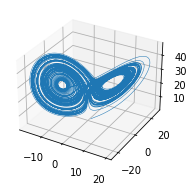

In [5]:
# Generate data
# Lorenz System

def lorenz(Z, t, sigma, rho, beta):
    x, y, z = Z
    return [sigma*(y-x), x*(rho-z)-y, x*y-beta*z]

x0 = [1, 1, 1]
t = np.linspace(0, 100, 100000)
sol = odeint(lorenz, x0, t, args=(10, 28, 8/3))

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol[:,0], sol[:,1], sol[:,2], lw=0.5)
plt.show()


In [6]:
# Build hankel matrix

delays = 100
sysdim = sol.shape[1]
dt = t[1] - t[0]

def build_hankel(x, delays):
    H = np.zeros((delays, len(x)-delays))
    for i in range(delays):
        H[i, :] = x[i: i+H.shape[1]]
    
    return H

measurements = sol[:, 0]
H = build_hankel(measurements, delays)
print('H_shape: ', H.shape)
print('dt : {}'.format(dt*delays))

H_shape:  (100, 99900)
dt : 0.10000100001000009


We would like to find a mapping between the time delays $\mathbf{\hat{y}} = [x_i, x_{i+1}, \ldots, x_{i+n-1}]$ and the full state system $\mathbf z_i = [x_i, y_i, z_i]$

$$ \mathbf z = \mathbf f(\hat{\mathbf y}) $$

Can we approximate the function $\mathbf f$ by a neural network?

In [13]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

# Define model
class network(nn.Module):
    def __init__(self, input_dim=100, output_dim=3):
        super(network, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim 
        self.l1 = nn.Linear(self.input_dim, 50)
        self.l2 = nn.Linear(50, 10)
        self.l3 = nn.Linear(10, self.output_dim)
    
    def forward(self, x):
        x = F.elu(self.l1(x))
        x = F.elu(self.l2(x))
        x = self.l3(x)
        return x

model = network(delays, sysdim)
print(model)


network(
  (l1): Linear(in_features=100, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (l3): Linear(in_features=10, out_features=3, bias=True)
)


### Prepare data

In [14]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

# Prepare data
X = H.T
y = sol[:X.shape[0], :]

# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                        train_size=.8, shuffle=True)

# Specify the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Turn numpy arrays into PyTorch Tensors
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

print(x_train.shape)
print(x_test.shape)

trainset = TensorDataset(x_train, y_train)
testset = TensorDataset(x_test, y_test)

# Prepare data for training
bs = 30
trainset_dl = DataLoader(trainset, batch_size=bs, shuffle=False)
testset_dl = DataLoader(testset, batch_size=bs, shuffle=False)

torch.Size([79920, 100])
torch.Size([19980, 100])


In [15]:
# Define optimizer and loss function
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [16]:
# Define training loop
def train_loop(model, loss_fn, optim, trainset_dl, epochs=100):
    # Loop through epochs
    for i in range(epochs):
        # Loop through batches
        for xb, yb in trainset_dl:
            # 1. Forward pass
            y_pred = model(xb)
            # 2. Compute loss
            loss = loss_fn(y_pred, yb)
            # 3. Backward pass (compute gradients)
            loss.backward()
            # 4. Apply optimization step
            optim.step()
            # 5. Set gradients to zero 
            # (Pytorch accumulates gradients otherwise) 
            optim.zero_grad()

        print('Epoch: {}, Loss: {}'.format(i, loss))

train_loop(model, loss_fn, optim, trainset_dl, epochs=20)


Epoch: 0, Loss: 0.5656242966651917
Epoch: 1, Loss: 0.30349647998809814
Epoch: 2, Loss: 0.13677945733070374
Epoch: 3, Loss: 0.27215486764907837
Epoch: 4, Loss: 0.1674385666847229
Epoch: 5, Loss: 0.08615739643573761
Epoch: 6, Loss: 0.09106133878231049
Epoch: 7, Loss: 0.11768429726362228
Epoch: 8, Loss: 0.12136854231357574
Epoch: 9, Loss: 0.07748258113861084
Epoch: 10, Loss: 0.0548139363527298
Epoch: 11, Loss: 0.05317696928977966
Epoch: 12, Loss: 0.053721655160188675
Epoch: 13, Loss: 0.046219486743211746
Epoch: 14, Loss: 0.044676993042230606
Epoch: 15, Loss: 0.050935469567775726
Epoch: 16, Loss: 0.04768767207860947
Epoch: 17, Loss: 0.05445224791765213
Epoch: 18, Loss: 0.05129951983690262
Epoch: 19, Loss: 0.06674422323703766


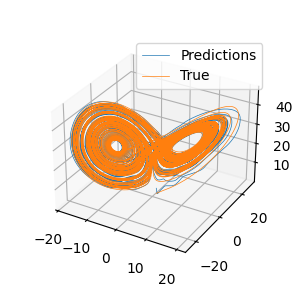

In [17]:
# Plot results
%matplotlib widget
# Get predictions
with torch.no_grad():
    y_pred = model(torch.tensor(H.T, dtype=torch.float32))

# Plot predictions
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')
ax.plot(y_pred[:,0], y_pred[:,1], y_pred[:,2], lw=.5, label='Predictions')
ax.plot(y[:,0], y[:,1], y[:,2], lw=.5, label='True')
ax.legend()
plt.show()


### Problem 1
Fill in the blanks to perform both training and testing on every epoch

In [ ]:
# Define training loop
def train_step(model, loss_fn, optim, trainset_dl):
    ### Write a training step

    return loss

def test_step(model, loss_fn, optim, testset_dl):
    ### And a test step

    return avg_loss 

def fit(model, loss_fn, optim, trainset_dl, testset_dl, epochs=100):
    train_loss = []
    test_loss = []
    for i in range(epochs):
        ### Perform both train and test steps every epoch 

        print('Epoch: {}, Train loss: {}, Test loss: {}'.format(i, train_loss[-1], test_loss[-1]))
    return train_loss, test_loss

loss_fn = nn.MSELoss()
model2 = network(delays, sysdim)
optim2 = torch.optim.Adam(model2.parameters(), lr=1e-3)
train_loss, test_loss = fit(model2, loss_fn, optim2, trainset_dl, testset_dl, epochs=20)

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(111)
### Plot training and test loss as a function of epochs

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()


#### What about the dominant eigen-time-modes of the delay embedding?

In [ ]:
# Find linear modes
high_dimensional_time_series = 

u, s, v = np.linalg.svd(high_dimensional_time_series, full_matrices=False)
modes = v.T

# Plot modes
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Linear modes')
ax.plot(modes[:,0], modes[:,1], modes[:,2], lw=.5, label='Modes')
ax.legend()
plt.show()


### Problem 2: Build an autoencoder to find the non-linear dominant modes

In [ ]:
class encoder(nn.Module):
    def __init__(self, input_dim=100, output_dim=3):
        super(encoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim 
        self.l1 = 
        self.l2 = 
        self.l3 = 
        self.l4 = 
                   
    def forward(self, x):
        x = 
        return x

### Define decoder


class autoencoder(nn.Module):
    def __init__(self, input_dim=100, latent_dim=3):
        super(autoencoder, self).__init__()
    
    def forward(self, x):

        return x

AEmodel = autoencoder(input_dim=100, latent_dim=3)



In [ ]:
# Prepare data for training
bs = 30
AEtrainset = TensorDataset(x_train, x_train)
AEtestset = TensorDataset(x_test, x_test)

# Prepare data for training
AEtrainset_dl = DataLoader(AEtrainset, batch_size=bs, shuffle=False)
AEtestset_dl = DataLoader(AEtestset, batch_size=bs, shuffle=False)

# Define optimizer and loss function
optimAE = torch.optim.Adam(AEmodel.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

train_loss, test_loss = fit(AEmodel, loss_fn, optimAE, AEtrainset_dl, AEtestset_dl, epochs=20)


In [ ]:
# plot train and test losses

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(train_loss, label='Train loss')
ax.plot(test_loss, label='Test loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()


In [ ]:
# Plot results
hankel = torch.tensor(H.T, dtype=torch.float32)
latent_z = AEmodel.encoder(hankel).detach().numpy()

# Plot predictions
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection='3d')

ax.plot(latent_z[:,0], latent_z[:,1], latent_z[:,2], lw=.5, label='Latent space')
ax.plot(y[:,0], y[:,1], y[:,2], lw=.5, label='Original Lorenz')
ax.plot(modes[:,0], modes[:,1], modes[:,2], lw=.5, label='Linear modes')

ax.set_title('Nonlinear Modes')
ax.legend()
plt.show()


Visualize Layers

In [56]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

AEmodel.encoder.l1.register_forward_hook(get_activation('l1'))
output_l1 = AEmodel(hankel)
l1_output = activation['l1'].detach().numpy()

AEmodel.encoder.l2.register_forward_hook(get_activation('l2'))
output_l2 = AEmodel(hankel)
l2_output = activation['l2'].detach().numpy()

AEmodel.encoder.l3.register_forward_hook(get_activation('l3'))
output_l3 = AEmodel(hankel)
l3_output = activation['l3'].detach().numpy()

output_list = [l1_output, l2_output, l3_output]

In [57]:
# Shape of layer outputs
l1_output.shape

(99900, 50)

In [ ]:
for i, out in enumerate(output_list):
    # SVD every output layer and plot
    u, s, v = np.linalg.svd(output_list[i].T, full_matrices=False)
    modes = v.T
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Layer: {}'.format(i+1))
    ax.plot(modes[:,0], modes[:,1], modes[:,2], lw=.5, label='Modes')
    ax.legend()
    plt.show()


Saving and Loading Models

In [ ]:
# Save model
torch.save(AEmodel.state_dict(), 'AEmodel.pt')

# Load model
AEmodel2 = autoencoder(input_dim=100, latent_dim=3)
AEmodel2.load_state_dict(torch.load('AEmodel.pt'))
AEmodel2.eval()

# print and compare first parameter of AE model and loaded model
print(AEmodel.encoder.l1.weight[0])
print(AEmodel.encoder.l1.weight[0] == AEmodel2.encoder.l1.weight[0])



### Can you discover a flow map for Lorenz?

$$ \mathbf z_{i+1} = \mathbf f(\mathbf z_{i}) $$
